<a href="https://colab.research.google.com/github/bsussel3/2023-s1-ci/blob/main/solucao/roteiro_atividade_02_EA991_1s2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 02: Reconhecimento de Atividades Humanas com kNN, SVM e _Random Forest_

<img src="https://github.com/EA991-Lab/utils/blob/main/figs/HAR_acc_gyr.png?raw=true">

*Dataset*: DAGHAR - https://zenodo.org/records/13987073

Github: https://github.com/H-IAAC/DAGHAR

O *benchmark* DAGHAR é uma coleção curada de conjuntos de dados projetada para estudos de adaptação de domínio e generalização de domínio em tarefas ligadas ao reconhecimento de atividades humanas (HAR, do inglês *human activity recognition*). As amostras disponíveis contêm dados brutos de sensores inerciais (acelerômetro e giroscópio) provenientes exclusivamente de *smartphones*.

Nesta atividade, vamos trabalhar com a *baseline view* do DAGHAR, que preserva ao máximo as características dos *datasets* originais (como a taxa de amostragem).

**Informações padronizadas:**

- 6 classes

| Rótulo    | Atividade |
| :----:    |    :---   
| 0   | Estar sentado       
| 1   | Ficar em pé        
| 2   | Caminhar        
| 3   | Subir escadas      
| 4   | Descer escadas
| 5   | Correr      

- Cada amostra contém janelas de 3 segundos (sem sobreposição) concatenadas de Acc-x, Acc-y, Acc-z, Gyr-x, Gyr-y, Gyr-z.



## Preâmbulo: Baixando o DAGHAR _baseline_

In [ ]:
import requests
import os
from pathlib import Path
from zipfile import ZipFile

# Caminho para a pasta que conterá o dataset
data_path = Path("data/")

def get_DARGHAR_data():
    if not os.path.exists(data_path):
        os.makedirs("data/", exist_ok=True)

        # Baixando o dataset do Zenodo
        data_url = "https://zenodo.org/records/13987073/files/baseline_view.zip?download=1"
        print(f"Baixando dados de {data_url}...")

        #Baseline view
        with open("baseline_view.zip", "wb") as f:
            request = requests.get(data_url)
            f.write(request.content)

        # Unzip
        targ_dir = "data"
        print(f"Extraindo dados para {targ_dir}...")
        with ZipFile("baseline_view.zip") as zip_ref:
            zip_ref.extractall(targ_dir)
    else:
        print("Dataset já baixado!")

#Baixando o dataset DAGHAR completo
get_DARGHAR_data()

Baixando dados de https://zenodo.org/records/13987073/files/baseline_view.zip?download=1...
Extraindo dados para data...


## Parte 1: Conhecendo detalhes do problema e do *dataset*

Escolha um conjunto de dados que compõe o DAGHAR e faça o carregamento das partições de treinamento, validação e teste.

**Passos:**
- definir o nome do subdiretório correspondente ao *dataset*;
- ler os arquivos `train.csv`, `validation.csv` e `test.csv`.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Caminho para a pasta que conterá o dataset
folder = "KuHar"
dataset_path = data_path / folder

#Leitura das partições de treinamento, validação e teste
data_train = pd.read_csv(dataset_path / "train.csv")
data_val = pd.read_csv(dataset_path / "validation.csv")
data_test = pd.read_csv(dataset_path / "test.csv")

print(f"Dimensão do dataset de treinamento: {data_train.shape}")
print(f"Dimensão do dataset de validação: {data_val.shape}")
print(f"Dimensão do dataset de teste: {data_test.shape}")


Dimensão do dataset de treinamento: (1386, 1812)
Dimensão do dataset de validação: (426, 1812)
Dimensão do dataset de teste: (144, 1812)


In [ ]:
#Lista com os nomes das classes na ordem correspondente aos rótulos numéricos
class_names = ['Sitting','Standing','Walking','Upstairs','Downstairs','Running']

#mapeamento dos rótulos padronizados para os nomes das classes no DAGHAR
label_map = {0:'Sitting',1:'Standing',2:'Walking',3:'Upstairs',4:'Downstairs',5:'Running'}

O `DataFrame` correspondente a cada *dataset* contém colunas adicionais com informações específicas (como índice de usuário) que não serão exploradas na atividade. Por isso, é necessário realizar uma limpeza inicial a fim de reter apenas as medidas de acelerômetro e giroscópio juntamente com o rótulo da atividade.

a) Sorteie aleatoriamente uma amostra de cada classe e apresente as séries temporais correspondentes aos três eixos de acelerômetro e de giroscópio. Discuta brevemente o perfil das atividades com base nestas séries temporais.

b) No problema de HAR, a representação no domínio da frequência para cada sinal (Acc-x, Acc-y, ..., Gyr-z) tende a favorecer a separação das classes, levando a um agrupamento das amostras de acordo com a "energia" da atividade. Por isso, vamos aplicar a transformada de Fourier a cada sinal básico (Acc-x, Acc-y, $\ldots$, Gyr-z) e gerar um vetor de características formado pela concatenação da magnitude dos espectros:

$$\text{Vetor de atributos} = [\, |\text{DFT}(\text{Acc-x})|\;,\;|\text{DFT}(\text{Acc-y})|\;,\;|\text{DFT}(\text{Acc-z})|\;,\; |\text{DFT}(\text{Gyr-x})|\;,\; |\text{DFT}(\text{Gyr-y})|\;,\; |\text{DFT}(\text{Gyr-z})|]$$

Prepare, então, uma rotina que faça esta transformação das partições de treinamento, validação e teste. Em seguida, mostre a magnitude dos espectros das amostras selecionadas no item anterior (uma por atividade) e comente.

c) Utilizando o algoritmo t-SNE (https://www.jmlr.org/papers/v9/vandermaaten08a.html), obtenha uma visualização em duas dimensões dos dados de treinamento e validação combinados.

**Sugestão:** utilize o `plotly.express` para gerar uma figura interativa; cada amostra será um ponto no espaço bidimensional cuja cor deve indicar a atividade humana correspondente.

### a)

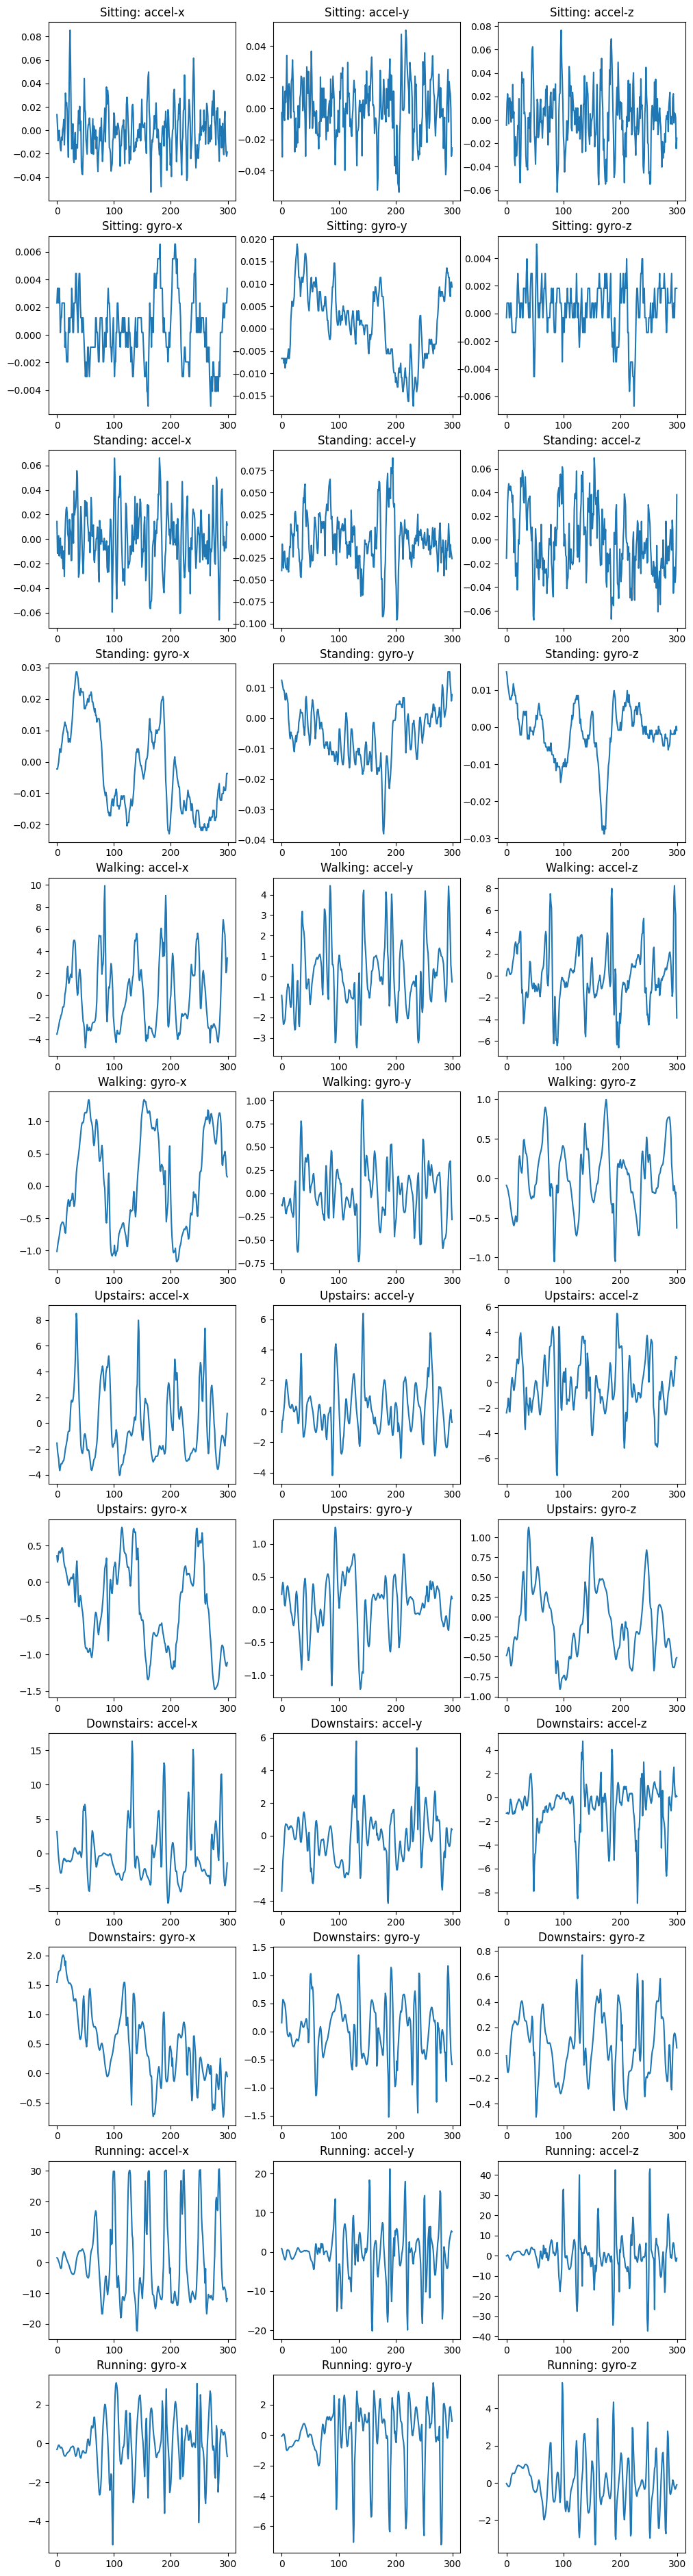

In [ ]:
sensors = ('accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z')

fig, axs = plt.subplots(12, 3, figsize=(12, 48))

index_ax = 0
for code in label_map.keys():
    filtered_train = data_train[data_train['standard activity code'] == code]
    sample = filtered_train.sample(random_state=42)
    for sensor in sensors:
        values = sample.loc[:,sensor+'-0':sensor+'-299'].values.T
        ax = axs.flat[index_ax]
        ax.plot(np.arange(300), values)
        ax.set_title(f"{label_map[code]}: {sensor}")

        index_ax += 1

plt.show()

### b)

In [ ]:
def fft_transform(df):
    data = None
    for sensor in sensors:
        sensor_data = np.absolute(np.fft.fft(df.loc[:,sensor+'-0':sensor+'-299']))
        if data is None:
            data = sensor_data
        else:
            data = np.concatenate((data, sensor_data), axis=1)

    filler = df.loc[:,'gyro-end-time':'standard activity code']
    data = np.concatenate((data, filler), axis=1)
    fft_df = pd.DataFrame(data, columns=df.columns)

    return fft_df

fft_train = fft_transform(data_train)
fft_val = fft_transform(data_val)
fft_test = fft_transform(data_test)

print(f"Dimensão do dataset de treinamento: {fft_train.shape}")
print(f"Dimensão do dataset de validação: {fft_val.shape}")
print(f"Dimensão do dataset de teste: {fft_test.shape}")

Dimensão do dataset de treinamento: (1386, 1812)
Dimensão do dataset de validação: (426, 1812)
Dimensão do dataset de teste: (144, 1812)


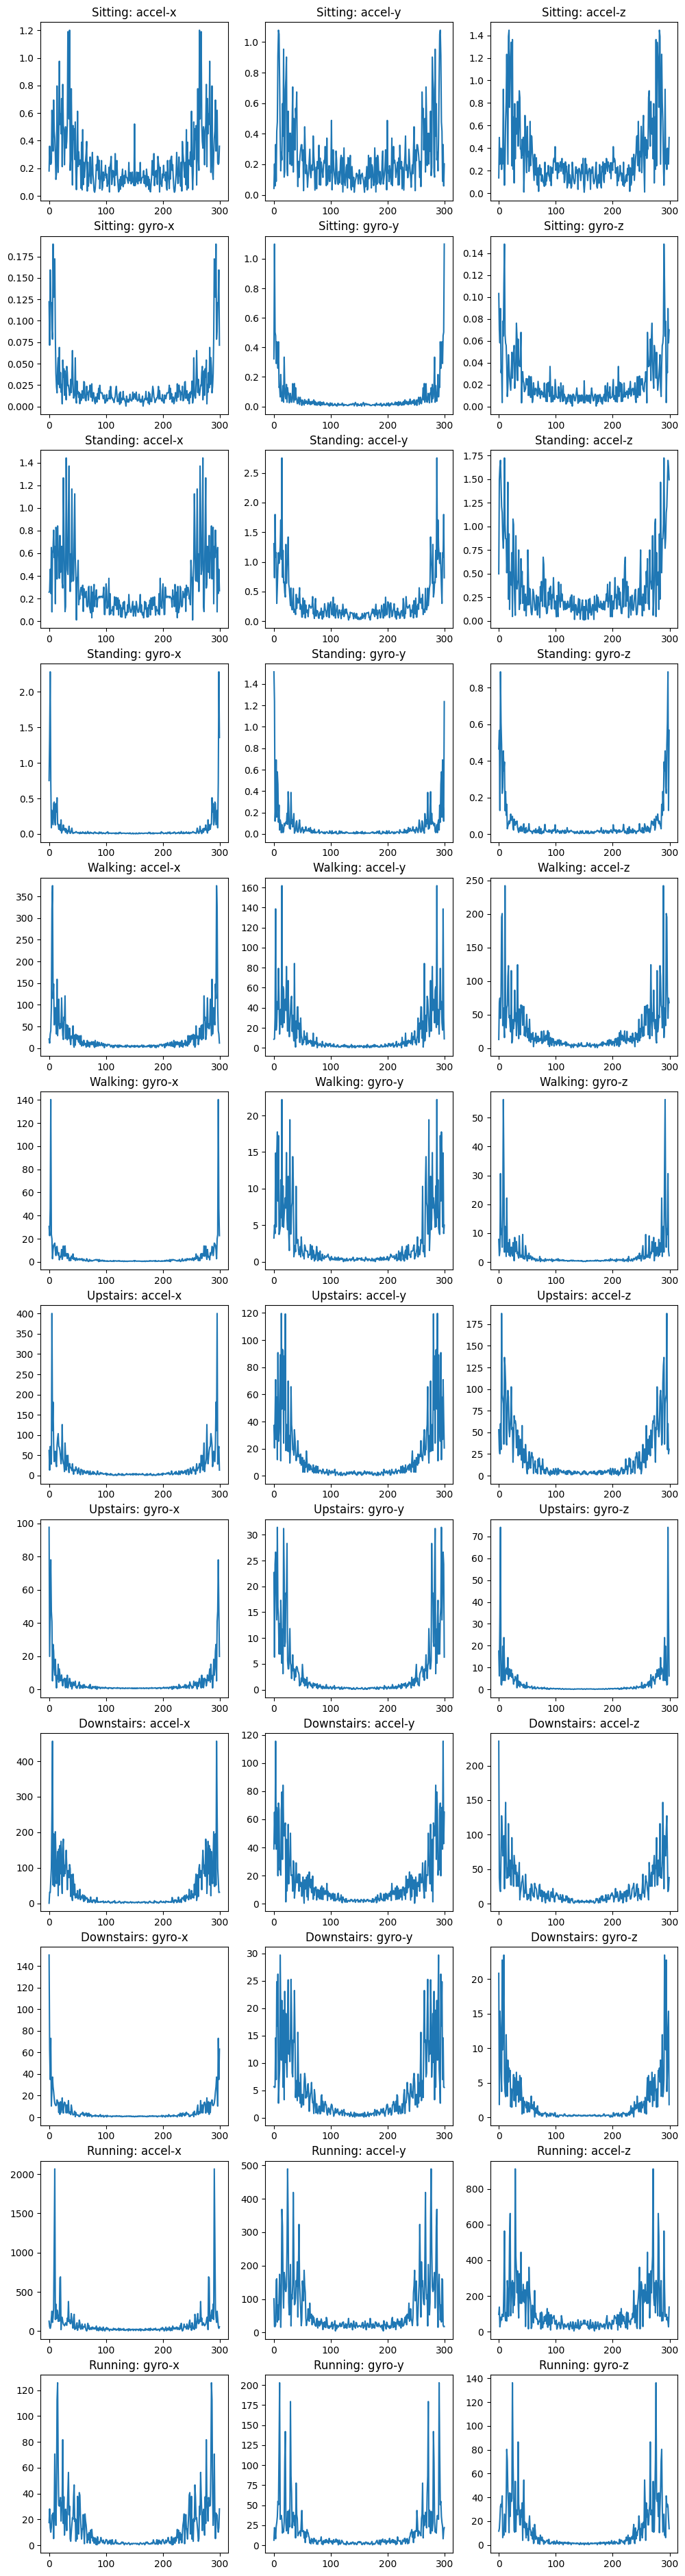

In [ ]:
fig, axs = plt.subplots(12, 3, figsize=(12, 48))

index_ax = 0
for code in label_map.keys():
    filtered_train = fft_train[fft_train['standard activity code'] == code]
    sample = filtered_train.sample(random_state=42)
    for sensor in sensors:
        values = sample.loc[:,sensor+'-0':sensor+'-299'].values.T
        ax = axs.flat[index_ax]
        ax.plot(np.arange(300), values)
        ax.set_title(f"{label_map[code]}: {sensor}")

        index_ax += 1

plt.show()

### c)

In [ ]:
pd.concat((fft_train, fft_val)).loc[:,'accel-x-0':'gyro-z-299'].shape

(1812, 1800)

In [ ]:
from sklearn import manifold

""" Vamos usar uma técnica chamada t-SNE para mapear os dados numa representação 2D de forma não-linear buscando preservar as relações
    de vizinhança (probabilística) entre as amostras.
"""
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    #init="random",
    #random_state=0,
)

fft_concat_train = pd.concat((fft_train, fft_val))
X_t_sne = t_sne.fit_transform(fft_concat_train.loc[:,'accel-x-0':'gyro-z-299'])

#DataFrame com o resultado do t-SNE
tsne_result = pd.DataFrame(X_t_sne,columns=['tsne1','tsne2'])

In [ ]:
tsne_result.head()

tsne1     tsne2
0 -46.824692 -8.298145
1 -27.227736 -4.912794
2 -30.063999  0.487136
3 -35.881111  7.219255
4 -49.435532 -6.843777

In [ ]:
import plotly.express as px

fig = px.scatter(tsne_result, x='tsne1', y='tsne2', color=fft_concat_train["standard activity code"] ,labels={'color': 'Atividade'})

fig.update_layout(legend=dict(
    orientation="h",
    entrywidth=70,
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=0.8
))

fig.show()

## Parte 2: Aplicação de SVM

Ajuste de hiperparâmetros com busca em grade e validação cruzada (*holdout*) + aplicação ao conjunto de teste

**Nota:** para usar um conjunto de validação pré-estabelecido junto ao `GridSearchCV`, é preciso:
1. Concatenar as partições de treinamento e validação;
2. Criar uma lista de índices 0 e -1 de mesmo tamanho que o total de amostras de treinamento + validação: os 0s aparecem para as amostras de validação, e -1s para as amostras de treinamento;
3. Usar `PredefinedSplit` com a lista de índices para preparar um separador de dados de validação;
4. Passar o *splitter* através do parâmetro `cv` do `GridSearchCV`.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import \
    classification_report, \
    confusion_matrix, \
    f1_score, \
    accuracy_score, \
    ConfusionMatrixDisplay

d) Apresente uma curva de variação de uma métrica de desempenho (e.g., $F_1$-*score*) nos dados de validação em função da largura da função *kernel* considerando a opção de *kernel* Gaussiano (ou `rbf`). Comente.

e) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: acurácia, $F_1$-*score* e matriz de confusão.


In [ ]:
data_train.head()

accel-x-0  accel-x-1  accel-x-2  accel-x-3  accel-x-4  accel-x-5  \
0  -0.044137  -0.071939  -0.059459  -0.009567  -0.028807  -0.019420   
1   0.076250   0.077858   0.072395   0.067158   0.000937  -0.049944   
2  -0.022714  -0.034023  -0.002826  -0.018109  -0.029658  -0.013994   
3  -0.011004  -0.008461   0.001106   0.019939   0.026677  -0.004387   
4  -0.029378  -0.017133  -0.007478  -0.007424  -0.004992   0.002110   

   accel-x-6  accel-x-7  accel-x-8  accel-x-9  ...  gyro-start-time   index  \
0  -0.005382  -0.003268  -0.010541  -0.010532  ...        12.141000  1201.0   
1  -0.106950  -0.120721  -0.089627  -0.063963  ...        39.441002  3901.0   
2  -0.031590  -0.018254   0.003103  -0.004098  ...        40.537998  3901.0   
3   0.009816   0.002581  -0.018661  -0.018351  ...        43.363998  3301.0   
4   0.013817  -0.002918   0.013626  -0.012510  ...        21.242001  2101.0   

     user  serial  accel-start-time                   csv  timestamp diff  \
0  1077.0       1         12.140000  0.Stand/1077_A_1.csv        0.008000   
1  1065.0       1         39.441002  0.Stand/1065_A_1.csv        0.010002   
2  1032.0       1         40.539001  0.Stand/1032_A_1.csv        0.018002   
3  1071.0       1         43.362999  0.Stand/1071_A_1.csv        0.008999   
4  1053.0       1         21.250999  0.Stand/1053_A_1.csv        0.008999   

   activity code  window  standard activity code  
0              0       4                       1  
1              0      13                       1  
2              0      13                       1  
3              0      11                       1  
4              0       7                       1  

[5 rows x 1812 columns]

In [ ]:
X_train = fft_train.loc[:,'accel-x-0':'gyro-z-299'].values
X_val = fft_val.loc[:,'accel-x-0':'gyro-z-299'].values
X_test = fft_test.loc[:,'accel-x-0':'gyro-z-299'].values

y_train = fft_train['standard activity code'].values.astype(int)
y_val = fft_val['standard activity code'].values.astype(int)
y_test = fft_test['standard activity code'].values.astype(int)

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

In [ ]:
print(f"Dimensão das features de treinamento: {X_train.shape}")
print(f"Dimensão das features de validação: {X_val.shape}")
print(f"Dimensão das features de teste: {X_test.shape}")
print(f"Dimensão das features de teste: {X_train_val.shape}")

Dimensão das features de treinamento: (1386, 1800)
Dimensão das features de validação: (426, 1800)
Dimensão das features de teste: (144, 1800)
Dimensão das features de teste: (1812, 1800)


In [ ]:
print(f"Dimensão das features de treinamento: {y_train.shape}")
print(f"Dimensão das features de validação: {y_val.shape}")
print(f"Dimensão das features de teste: {y_test.shape}")
print(f"Dimensão das features de teste: {y_train_val.shape}")

Dimensão das features de treinamento: (1386,)
Dimensão das features de validação: (426,)
Dimensão das features de teste: (144,)
Dimensão das features de teste: (1812,)


In [ ]:
y_train_val

array([1, 1, 1, ..., 4, 4, 4])

In [ ]:
n_features = X_train_val.shape[1]

np.log10(1 / n_features)


np.float64(-3.255272505103306)

In [ ]:
n_features = X_train_val.shape[1]

# Define o grid de parâmetros
param_grid = {
    'C': np.logspace(-3, 1, 5),
    'gamma': np.logspace(-9, -3),
    'kernel': ['rbf', 'sigmoid']
}

#lista de índices para a separação novamente em X_train e X_val dentro do GridSearch
split_index = [-1]*len(X_train) + [0]*len(X_val)

#cria o splitter de dados
pds = PredefinedSplit(test_fold = split_index)

#define a busca em grade
grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=pds,
    verbose=2,
)


In [ ]:
grid.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 500 candidates, totalling 500 fits
[CV] END ...................C=0.001, gamma=1e-09, kernel=rbf; total time=   4.4s
[CV] END ...............C=0.001, gamma=1e-09, kernel=sigmoid; total time=   2.9s
[CV] END ..C=0.001, gamma=1.3257113655901108e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=1.3257113655901108e-09, kernel=sigmoid; total time=   3.3s
[CV] END ..C=0.001, gamma=1.7575106248547893e-09, kernel=rbf; total time=   3.7s
[CV] END C=0.001, gamma=1.7575106248547893e-09, kernel=sigmoid; total time=   3.5s
[CV] END ..C=0.001, gamma=2.3299518105153718e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=2.3299518105153718e-09, kernel=sigmoid; total time=   3.5s
[CV] END ...C=0.001, gamma=3.088843596477485e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=3.088843596477485e-09, kernel=sigmoid; total time=   2.9s
[CV] END ...C=0.001, gamma=4.094915062380419e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=4.0949150623804

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'gamma': array([1.00000000e-09, 1.32571137e-09, 1.75751062e-09, 2.32995181e-09,
       3.08884360e-09, 4.09491506e-09, 5.42867544e-09, 7.19685673e-09,
       9.54095476e-09, 1.26485522e-08, 1.67683294e-08, 2.22299648e-08,
       2.94705170e-0...
       2.68269580e-06, 3.55648031e-06, 4.71486636e-06, 6.25055193e-06,
       8.28642773e-06, 1.09854114e-05, 1.45634848e-05, 1.93069773e-05,
       2.55954792e-05, 3.39322177e-05, 4.49843267e-05, 5.96362332e-05,
       7.90604321e-05, 1.04811313e-04, 1.38949549e-04, 1.84206997e-04,
       2.44205309e-04, 3.23745754e-04, 4.29193426e-04, 5.68986603e-04,
       7.54312006e-04, 1.00000000e-03]),
                         'kernel': ['rbf', 'sigmoid']},
             verbose=2)

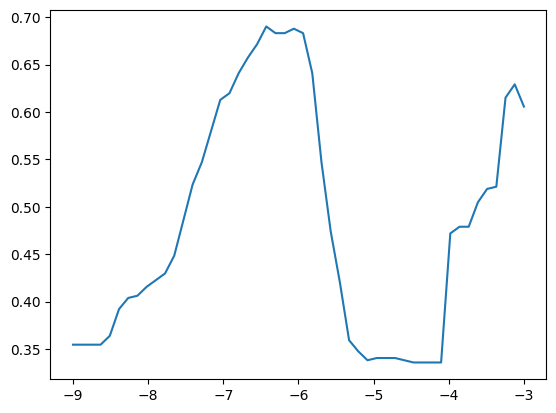

In [ ]:
# Score com C=0.1 e kernel='rbf', variando gamma
scores = grid.cv_results_['mean_test_score'][200:300:2]
gamma = np.linspace(-9, -3)

fig, ax = plt.subplots()
ax.plot(gamma, scores)
plt.show()

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names, zero_division=np.nan))
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

     Sitting       0.50      1.00      0.67        24
    Standing        nan      0.00      0.00        24
     Walking       0.81      0.92      0.86        24
    Upstairs       1.00      0.46      0.63        24
  Downstairs       0.56      0.42      0.48        24
     Running       0.60      1.00      0.75        24

    accuracy                           0.63       144
   macro avg       0.69      0.63      0.56       144
weighted avg       0.69      0.63      0.56       144

Acurácia: 0.6319444444444444
F1-score: 0.5640289449112978


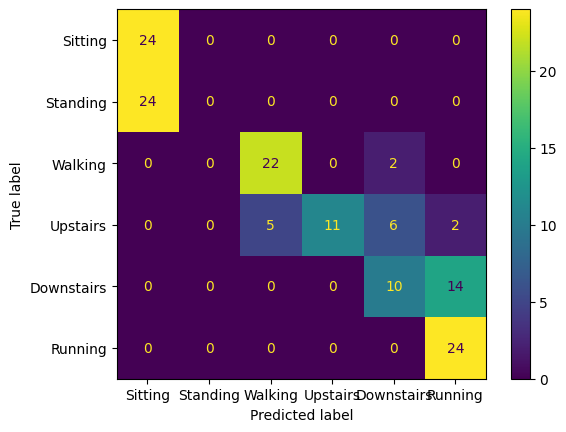

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names).plot()

## Parte 3: Aplicação de kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid = {
    'n_neighbors': np.arange(1, 51),
    'p': (1, 2),
    'leaf_size': [int(x) for x in np.logspace(0, 2, 5)],
}

grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=pds,
    verbose=2,
)

In [ ]:
grid.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 500 candidates, totalling 500 fits
[CV] END ....................leaf_size=1, n_neighbors=1, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=1, p=2; total time=   0.4s
[CV] END ....................leaf_size=1, n_neighbors=2, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=2, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=3, p=1; total time=   2.3s
[CV] END ....................leaf_size=1, n_neighbors=3, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=4, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=4, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=5, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=5, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=6, p=1; total time=   2.1s
[CV] END ....................leaf_size=1, n_ne

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 3, 10, 31, 100],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                         'p': (1, 2)},
             verbose=2)

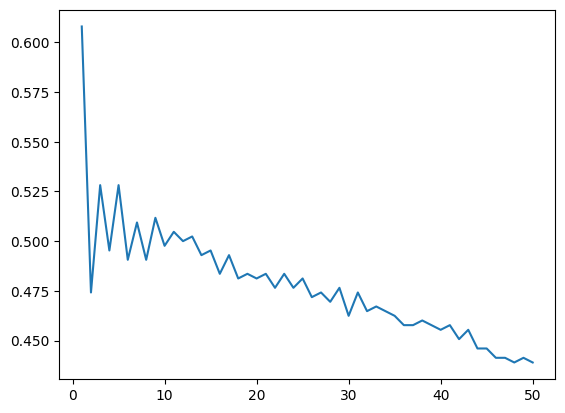

In [ ]:
# Score com leaf_size=1 e p=1
scores = grid.cv_results_['mean_test_score'][0:100:2]
n_neighbors = np.arange(1, 51)

fig, ax = plt.subplots()
ax.plot(n_neighbors, scores)
plt.show()

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names, zero_division=np.nan))
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

     Sitting       0.79      0.92      0.85        24
    Standing       0.90      0.75      0.82        24
     Walking       0.76      0.92      0.83        24
    Upstairs       0.80      0.50      0.62        24
  Downstairs       0.89      1.00      0.94        24
     Running       0.92      0.96      0.94        24

    accuracy                           0.84       144
   macro avg       0.84      0.84      0.83       144
weighted avg       0.84      0.84      0.83       144

Acurácia: 0.8402777777777778
F1-score: 0.8316434899596467


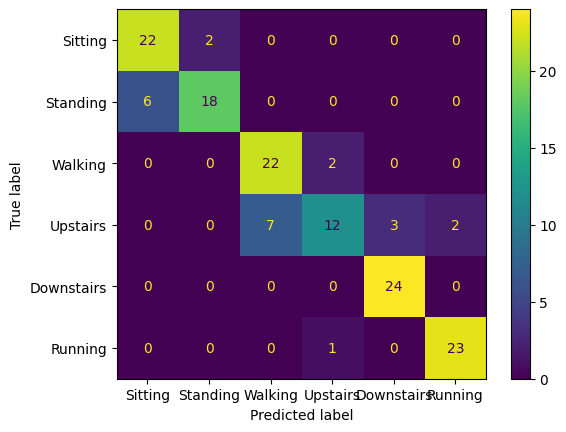

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names).plot()

f) Mostre em um gráfico a variação da mesma métrica de desempenho no conjunto de validação em função do número de vizinhos ($k$). Comente.

g) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: acurácia, $F_1$-*score* e matriz de confusão.

## Parte 4: Aplicação de *Random Forest*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
param_grid = {
    'n_estimators': np.arange(40, 1001, 40),
    'criterion': ('gini', 'entropy'),
    'min_samples_split': np.logspace(-4, 0, 3),
    'min_samples_leaf': np.logspace(-3, -1, 3)
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=pds,
    verbose=2,
)

In [ ]:
grid.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 450 candidates, totalling 450 fits
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=40; total time=   2.2s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=80; total time=   4.6s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=120; total time=   5.7s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=160; total time=   8.4s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=200; total time=  10.0s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=240; total time=  11.9s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=280; total time=  14.5s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=320; total time=  15.7s
[CV] END criterion=gini, min_samples_leaf=0

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'min_samples_leaf': array([0.001, 0.01 , 0.1  ]),
                         'min_samples_split': array([1.e-04, 1.e-02, 1.e+00]),
                         'n_estimators': array([  40,   80,  120,  160,  200,  240,  280,  320,  360,  400,  440,
        480,  520,  560,  600,  640,  680,  720,  760,  800,  840,  880,
        920,  960, 1000])},
             verbose=2)

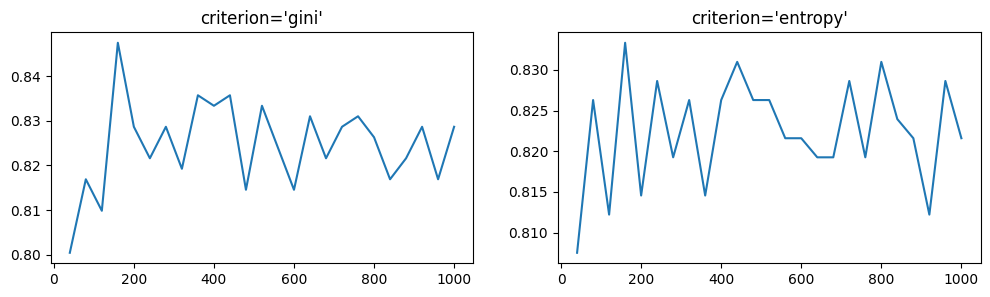

In [ ]:
# Score com min_samples_leaf=0.01 e min_samples_split=0.0001
scores_gini = grid.cv_results_['mean_test_score'][25:50:1]
scores_entropy = grid.cv_results_['mean_test_score'][250:275:]
n_estimators = np.arange(40, 1001, 40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.set_title("criterion='gini'")
ax1.plot(n_estimators, scores_gini)
ax2.set_title("criterion='entropy'")
ax2.plot(n_estimators, scores_entropy)
plt.show()

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names, zero_division=np.nan))
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

     Sitting       0.76      0.79      0.78        24
    Standing       0.78      0.75      0.77        24
     Walking       0.96      0.92      0.94        24
    Upstairs       0.88      0.62      0.73        24
  Downstairs       0.60      0.50      0.55        24
     Running       0.67      1.00      0.80        24

    accuracy                           0.76       144
   macro avg       0.77      0.76      0.76       144
weighted avg       0.77      0.76      0.76       144

Acurácia: 0.7638888888888888
F1-score: 0.7591332876973028


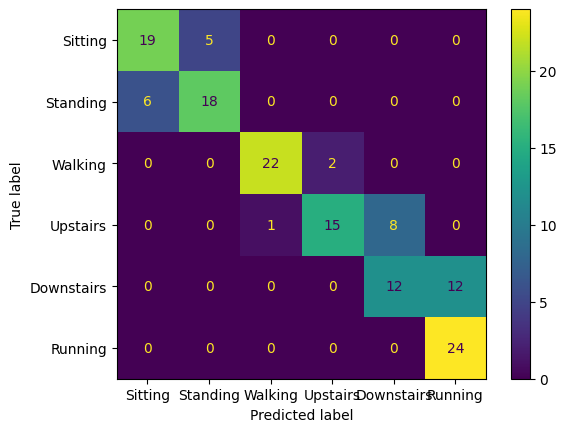

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names).plot()

h) Mostre o impacto do número de árvores (`n_estimators`) sobre o desempenho de validação considerando como função de impureza (`criterion`) o índice de Gini e a entropia. Comente.

i) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: acurácia, $F_1$-*score* e matriz de confusão.

## Parte 5: Extensão para outros dois *datasets*

j) Repita o procedimento adotado nas Partes 1 a 4 para outros dois *datasets* de sua escolha contidos no DAGHAR. Ao final de todos os passos, mostre numa tabela os desempenhos de teste alcançados pelos modelos nos três *datasets*.

| Modelo    | *Dataset* 1 | *Dataset* 2 | *Dataset* 3 |  Média e Desvio Padrão
| :----:    |    :---   |    :---   |    :---   | :---   
| SVM   |        
| kNN |        
| *Random Forest* |

k) Aplique, ao final, um teste estatístico não-paramétrico (e.g., Wilcoxon) em todos os pares de modelos - SVM vs. kNN, SVM vs. *Random Forest* e kNN vs. *Random Forest* e obtenha os p-valores. Verifique se há diferença que possa ser considerada significativa entre eles.


#### Dataset 2

In [80]:
#Caminho para a pasta que conterá o dataset
folder = "MotionSense"
dataset_path = data_path / folder

#Leitura das partições de treinamento, validação e teste
data_train = pd.read_csv(dataset_path / "train.csv")
data_val = pd.read_csv(dataset_path / "validation.csv")
data_test = pd.read_csv(dataset_path / "test.csv")

print(f"Dimensão do dataset de treinamento: {data_train.shape}")
print(f"Dimensão do dataset de validação: {data_val.shape}")
print(f"Dimensão do dataset de teste: {data_test.shape}")


Dimensão do dataset de treinamento: (3558, 1807)
Dimensão do dataset de validação: (420, 1807)
Dimensão do dataset de teste: (1062, 1807)


In [84]:
a = list(data_train.columns)
a.reverse()
a

['standard activity code',
 'window',
 'activity code',
 'csv',
 'serial',
 'index',
 'user',
 'gravity.z-149',
 'gravity.z-148',
 'gravity.z-147',
 'gravity.z-146',
 'gravity.z-145',
 'gravity.z-144',
 'gravity.z-143',
 'gravity.z-142',
 'gravity.z-141',
 'gravity.z-140',
 'gravity.z-139',
 'gravity.z-138',
 'gravity.z-137',
 'gravity.z-136',
 'gravity.z-135',
 'gravity.z-134',
 'gravity.z-133',
 'gravity.z-132',
 'gravity.z-131',
 'gravity.z-130',
 'gravity.z-129',
 'gravity.z-128',
 'gravity.z-127',
 'gravity.z-126',
 'gravity.z-125',
 'gravity.z-124',
 'gravity.z-123',
 'gravity.z-122',
 'gravity.z-121',
 'gravity.z-120',
 'gravity.z-119',
 'gravity.z-118',
 'gravity.z-117',
 'gravity.z-116',
 'gravity.z-115',
 'gravity.z-114',
 'gravity.z-113',
 'gravity.z-112',
 'gravity.z-111',
 'gravity.z-110',
 'gravity.z-109',
 'gravity.z-108',
 'gravity.z-107',
 'gravity.z-106',
 'gravity.z-105',
 'gravity.z-104',
 'gravity.z-103',
 'gravity.z-102',
 'gravity.z-101',
 'gravity.z-100',
 'grav

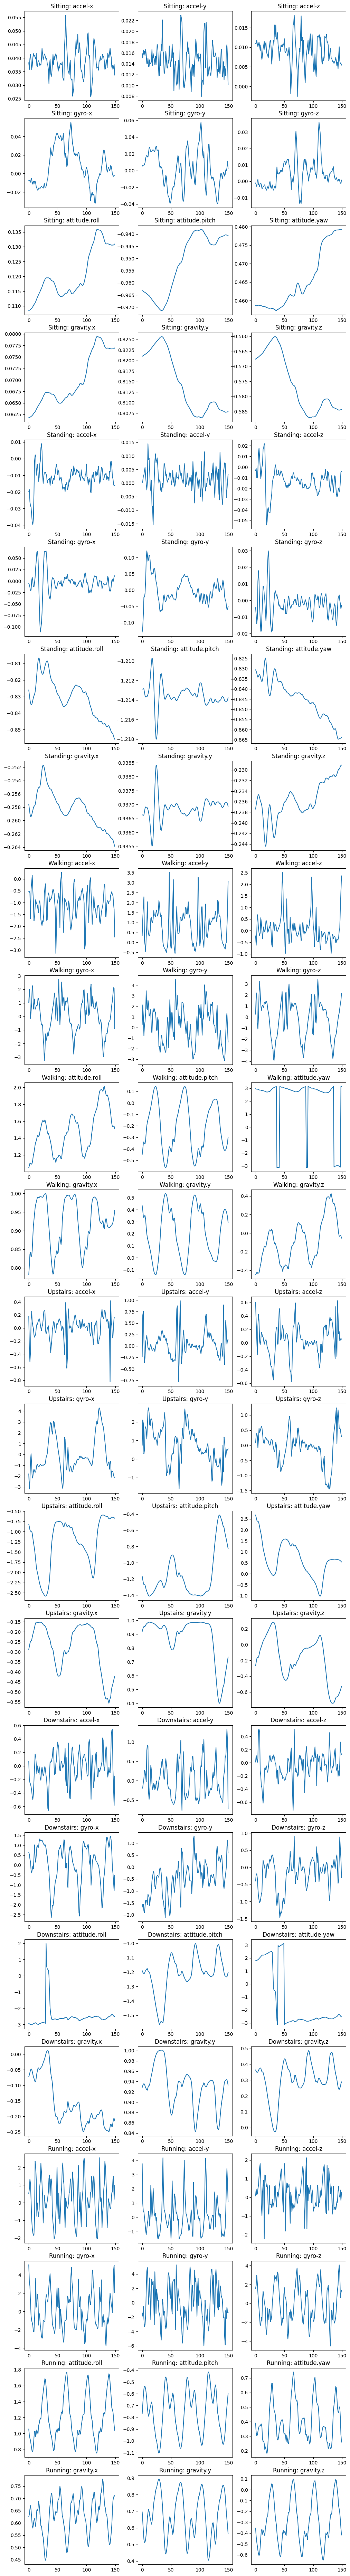

In [88]:
sensors = ('accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z',
           'attitude.roll', 'attitude.pitch', 'attitude.yaw',
           'gravity.x', 'gravity.y', 'gravity.z')

fig, axs = plt.subplots(24, 3, figsize=(12, 96))

index_ax = 0
for code in label_map.keys():
    filtered_train = data_train[data_train['standard activity code'] == code]
    sample = filtered_train.sample(random_state=42)
    for sensor in sensors:
        values = sample.loc[:,sensor+'-0':sensor+'-149'].values.T
        ax = axs.flat[index_ax]
        ax.plot(np.arange(150), values)
        ax.set_title(f"{label_map[code]}: {sensor}")

        index_ax += 1

plt.show()

In [89]:
def fft_transform_2(df):
    data = None
    for sensor in sensors:
        sensor_data = np.absolute(np.fft.fft(df.loc[:,sensor+'-0':sensor+'-149']))
        if data is None:
            data = sensor_data
        else:
            data = np.concatenate((data, sensor_data), axis=1)

    filler = df.loc[:,'user':'standard activity code']
    data = np.concatenate((data, filler), axis=1)
    fft_df = pd.DataFrame(data, columns=df.columns)

    return fft_df

fft_train = fft_transform_2(data_train)
fft_val = fft_transform_2(data_val)
fft_test = fft_transform_2(data_test)

print(f"Dimensão do dataset de treinamento: {fft_train.shape}")
print(f"Dimensão do dataset de validação: {fft_val.shape}")
print(f"Dimensão do dataset de teste: {fft_test.shape}")

Dimensão do dataset de treinamento: (3558, 1807)
Dimensão do dataset de validação: (420, 1807)
Dimensão do dataset de teste: (1062, 1807)


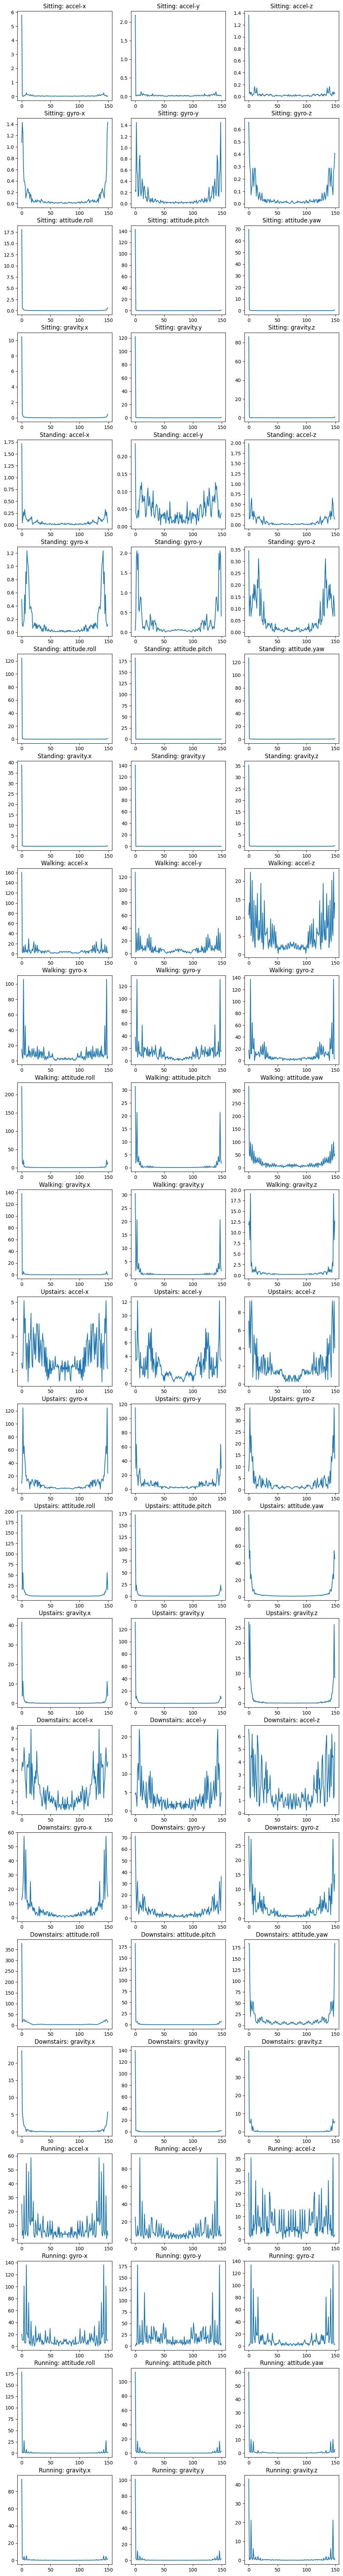

In [91]:
fig, axs = plt.subplots(24, 3, figsize=(12, 96))

index_ax = 0
for code in label_map.keys():
    filtered_train = fft_train[fft_train['standard activity code'] == code]
    sample = filtered_train.sample(random_state=42)
    for sensor in sensors:
        values = sample.loc[:,sensor+'-0':sensor+'-149'].values.T
        ax = axs.flat[index_ax]
        ax.plot(np.arange(150), values)
        ax.set_title(f"{label_map[code]}: {sensor}")

        index_ax += 1

plt.show()

In [94]:

""" Vamos usar uma técnica chamada t-SNE para mapear os dados numa representação 2D de forma não-linear buscando preservar as relações
    de vizinhança (probabilística) entre as amostras.
"""
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    #init="random",
    #random_state=0,
)

fft_concat_train = pd.concat((fft_train, fft_val))
X_t_sne = t_sne.fit_transform(fft_concat_train.loc[:,'accel-x-0':'gyro-z-149'])

#DataFrame com o resultado do t-SNE
tsne_result = pd.DataFrame(X_t_sne,columns=['tsne1','tsne2'])

In [95]:
fig = px.scatter(tsne_result, x='tsne1', y='tsne2', color=fft_concat_train["standard activity code"] ,labels={'color': 'Atividade'})

fig.update_layout(legend=dict(
    orientation="h",
    entrywidth=70,
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=0.8
))

fig.show()

In [96]:
X_train = fft_train.loc[:,'accel-x-0':'gyro-z-149'].values
X_val = fft_val.loc[:,'accel-x-0':'gyro-z-149'].values
X_test = fft_test.loc[:,'accel-x-0':'gyro-z-149'].values

y_train = fft_train['standard activity code'].values.astype(int)
y_val = fft_val['standard activity code'].values.astype(int)
y_test = fft_test['standard activity code'].values.astype(int)

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

In [ ]:
n_features = X_train_val.shape[1]

# Define o grid de parâmetros
param_grid = {
    'C': np.logspace(-3, 1, 5),
    'gamma': np.logspace(-9, -3),
    'kernel': ['rbf', 'sigmoid']
}

#lista de índices para a separação novamente em X_train e X_val dentro do GridSearch
split_index = [-1]*len(X_train) + [0]*len(X_val)

#cria o splitter de dados
pds = PredefinedSplit(test_fold = split_index)

#define a busca em grade
grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=pds,
    verbose=2,
)


In [ ]:
grid.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 500 candidates, totalling 500 fits
[CV] END ...................C=0.001, gamma=1e-09, kernel=rbf; total time=   4.4s
[CV] END ...............C=0.001, gamma=1e-09, kernel=sigmoid; total time=   2.9s
[CV] END ..C=0.001, gamma=1.3257113655901108e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=1.3257113655901108e-09, kernel=sigmoid; total time=   3.3s
[CV] END ..C=0.001, gamma=1.7575106248547893e-09, kernel=rbf; total time=   3.7s
[CV] END C=0.001, gamma=1.7575106248547893e-09, kernel=sigmoid; total time=   3.5s
[CV] END ..C=0.001, gamma=2.3299518105153718e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=2.3299518105153718e-09, kernel=sigmoid; total time=   3.5s
[CV] END ...C=0.001, gamma=3.088843596477485e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=3.088843596477485e-09, kernel=sigmoid; total time=   2.9s
[CV] END ...C=0.001, gamma=4.094915062380419e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=4.0949150623804

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'gamma': array([1.00000000e-09, 1.32571137e-09, 1.75751062e-09, 2.32995181e-09,
       3.08884360e-09, 4.09491506e-09, 5.42867544e-09, 7.19685673e-09,
       9.54095476e-09, 1.26485522e-08, 1.67683294e-08, 2.22299648e-08,
       2.94705170e-0...
       2.68269580e-06, 3.55648031e-06, 4.71486636e-06, 6.25055193e-06,
       8.28642773e-06, 1.09854114e-05, 1.45634848e-05, 1.93069773e-05,
       2.55954792e-05, 3.39322177e-05, 4.49843267e-05, 5.96362332e-05,
       7.90604321e-05, 1.04811313e-04, 1.38949549e-04, 1.84206997e-04,
       2.44205309e-04, 3.23745754e-04, 4.29193426e-04, 5.68986603e-04,
       7.54312006e-04, 1.00000000e-03]),
                         'kernel': ['rbf', 'sigmoid']},
             verbose=2)

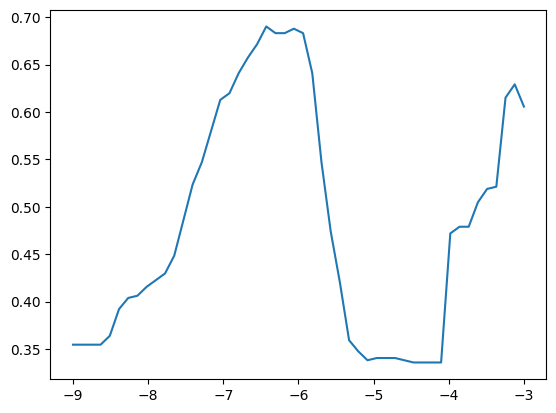

In [ ]:
# Score com C=0.1 e kernel='rbf', variando gamma
scores = grid.cv_results_['mean_test_score'][200:300:2]
gamma = np.linspace(-9, -3)

fig, ax = plt.subplots()
ax.plot(gamma, scores)
plt.show()

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names, zero_division=np.nan))
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

     Sitting       0.50      1.00      0.67        24
    Standing        nan      0.00      0.00        24
     Walking       0.81      0.92      0.86        24
    Upstairs       1.00      0.46      0.63        24
  Downstairs       0.56      0.42      0.48        24
     Running       0.60      1.00      0.75        24

    accuracy                           0.63       144
   macro avg       0.69      0.63      0.56       144
weighted avg       0.69      0.63      0.56       144

Acurácia: 0.6319444444444444
F1-score: 0.5640289449112978


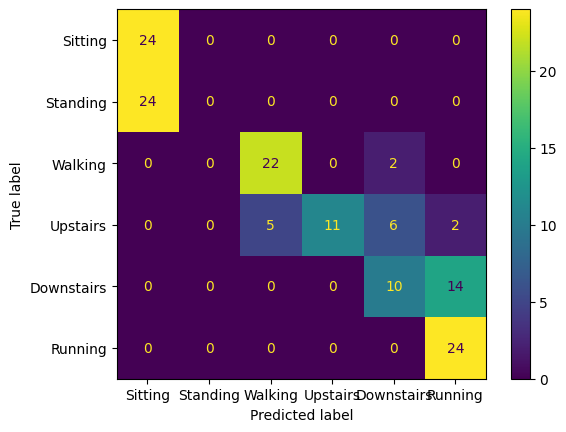

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names).plot()

In [ ]:
param_grid = {
    'n_neighbors': np.arange(1, 51),
    'p': (1, 2),
    'leaf_size': [int(x) for x in np.logspace(0, 2, 5)],
}

grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=pds,
    verbose=2,
)

In [ ]:
grid.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 500 candidates, totalling 500 fits
[CV] END ....................leaf_size=1, n_neighbors=1, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=1, p=2; total time=   0.4s
[CV] END ....................leaf_size=1, n_neighbors=2, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=2, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=3, p=1; total time=   2.3s
[CV] END ....................leaf_size=1, n_neighbors=3, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=4, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=4, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=5, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=5, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=6, p=1; total time=   2.1s
[CV] END ....................leaf_size=1, n_ne

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 3, 10, 31, 100],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                         'p': (1, 2)},
             verbose=2)

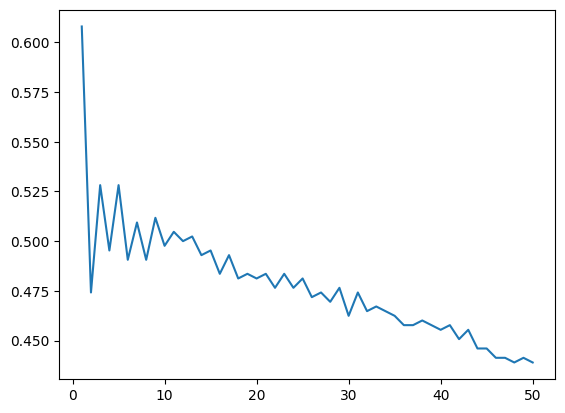

In [ ]:
# Score com leaf_size=1 e p=1
scores = grid.cv_results_['mean_test_score'][0:100:2]
n_neighbors = np.arange(1, 51)

fig, ax = plt.subplots()
ax.plot(n_neighbors, scores)
plt.show()

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names, zero_division=np.nan))
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

     Sitting       0.79      0.92      0.85        24
    Standing       0.90      0.75      0.82        24
     Walking       0.76      0.92      0.83        24
    Upstairs       0.80      0.50      0.62        24
  Downstairs       0.89      1.00      0.94        24
     Running       0.92      0.96      0.94        24

    accuracy                           0.84       144
   macro avg       0.84      0.84      0.83       144
weighted avg       0.84      0.84      0.83       144

Acurácia: 0.8402777777777778
F1-score: 0.8316434899596467


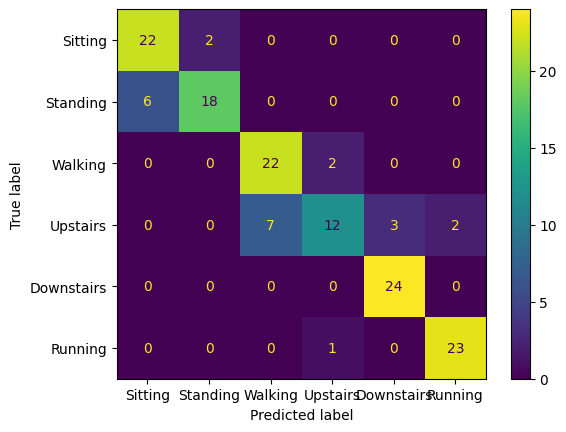

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names).plot()

In [ ]:
param_grid = {
    'n_estimators': np.arange(40, 1001, 40),
    'criterion': ('gini', 'entropy'),
    'min_samples_split': np.logspace(-4, 0, 3),
    'min_samples_leaf': np.logspace(-3, -1, 3)
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=pds,
    verbose=2,
)

In [ ]:
grid.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 450 candidates, totalling 450 fits
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=40; total time=   2.2s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=80; total time=   4.6s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=120; total time=   5.7s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=160; total time=   8.4s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=200; total time=  10.0s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=240; total time=  11.9s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=280; total time=  14.5s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=320; total time=  15.7s
[CV] END criterion=gini, min_samples_leaf=0

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'min_samples_leaf': array([0.001, 0.01 , 0.1  ]),
                         'min_samples_split': array([1.e-04, 1.e-02, 1.e+00]),
                         'n_estimators': array([  40,   80,  120,  160,  200,  240,  280,  320,  360,  400,  440,
        480,  520,  560,  600,  640,  680,  720,  760,  800,  840,  880,
        920,  960, 1000])},
             verbose=2)

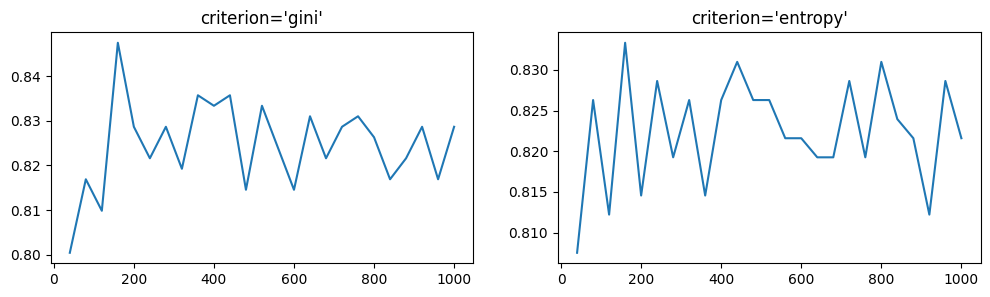

In [ ]:
# Score com min_samples_leaf=0.01 e min_samples_split=0.0001
scores_gini = grid.cv_results_['mean_test_score'][25:50:1]
scores_entropy = grid.cv_results_['mean_test_score'][250:275:]
n_estimators = np.arange(40, 1001, 40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.set_title("criterion='gini'")
ax1.plot(n_estimators, scores_gini)
ax2.set_title("criterion='entropy'")
ax2.plot(n_estimators, scores_entropy)
plt.show()

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names, zero_division=np.nan))
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

     Sitting       0.76      0.79      0.78        24
    Standing       0.78      0.75      0.77        24
     Walking       0.96      0.92      0.94        24
    Upstairs       0.88      0.62      0.73        24
  Downstairs       0.60      0.50      0.55        24
     Running       0.67      1.00      0.80        24

    accuracy                           0.76       144
   macro avg       0.77      0.76      0.76       144
weighted avg       0.77      0.76      0.76       144

Acurácia: 0.7638888888888888
F1-score: 0.7591332876973028


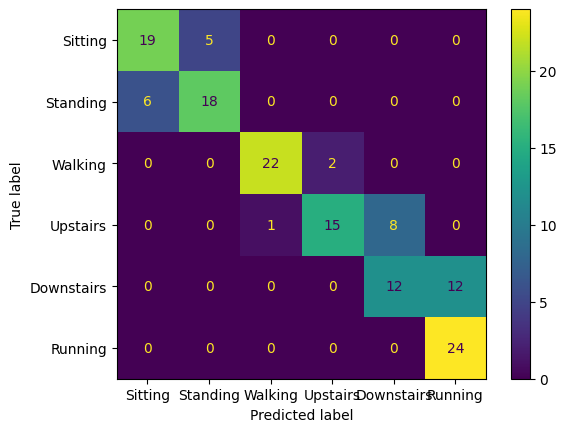

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names).plot()

#### Dataset 3

In [97]:
#Caminho para a pasta que conterá o dataset
folder = "WISDM"
dataset_path = data_path / folder

#Leitura das partições de treinamento, validação e teste
data_train = pd.read_csv(dataset_path / "train.csv")
data_val = pd.read_csv(dataset_path / "validation.csv")
data_test = pd.read_csv(dataset_path / "test.csv")

print(f"Dimensão do dataset de treinamento: {data_train.shape}")
print(f"Dimensão do dataset de validação: {data_val.shape}")
print(f"Dimensão do dataset de teste: {data_test.shape}")


Dimensão do dataset de treinamento: (8736, 368)
Dimensão do dataset de validação: (944, 368)
Dimensão do dataset de teste: (2596, 368)


In [98]:
a=list(data_train.columns)
a.reverse()
a

['standard activity code',
 'window',
 'user',
 'activity code',
 'timestamp-gyro',
 'timestamp-accel',
 'accel-timestamp diff',
 'gyro-z-59',
 'gyro-z-58',
 'gyro-z-57',
 'gyro-z-56',
 'gyro-z-55',
 'gyro-z-54',
 'gyro-z-53',
 'gyro-z-52',
 'gyro-z-51',
 'gyro-z-50',
 'gyro-z-49',
 'gyro-z-48',
 'gyro-z-47',
 'gyro-z-46',
 'gyro-z-45',
 'gyro-z-44',
 'gyro-z-43',
 'gyro-z-42',
 'gyro-z-41',
 'gyro-z-40',
 'gyro-z-39',
 'gyro-z-38',
 'gyro-z-37',
 'gyro-z-36',
 'gyro-z-35',
 'gyro-z-34',
 'gyro-z-33',
 'gyro-z-32',
 'gyro-z-31',
 'gyro-z-30',
 'gyro-z-29',
 'gyro-z-28',
 'gyro-z-27',
 'gyro-z-26',
 'gyro-z-25',
 'gyro-z-24',
 'gyro-z-23',
 'gyro-z-22',
 'gyro-z-21',
 'gyro-z-20',
 'gyro-z-19',
 'gyro-z-18',
 'gyro-z-17',
 'gyro-z-16',
 'gyro-z-15',
 'gyro-z-14',
 'gyro-z-13',
 'gyro-z-12',
 'gyro-z-11',
 'gyro-z-10',
 'gyro-z-9',
 'gyro-z-8',
 'gyro-z-7',
 'gyro-z-6',
 'gyro-z-5',
 'gyro-z-4',
 'gyro-z-3',
 'gyro-z-2',
 'gyro-z-1',
 'gyro-z-0',
 'gyro-y-59',
 'gyro-y-58',
 'gyro-y-57',

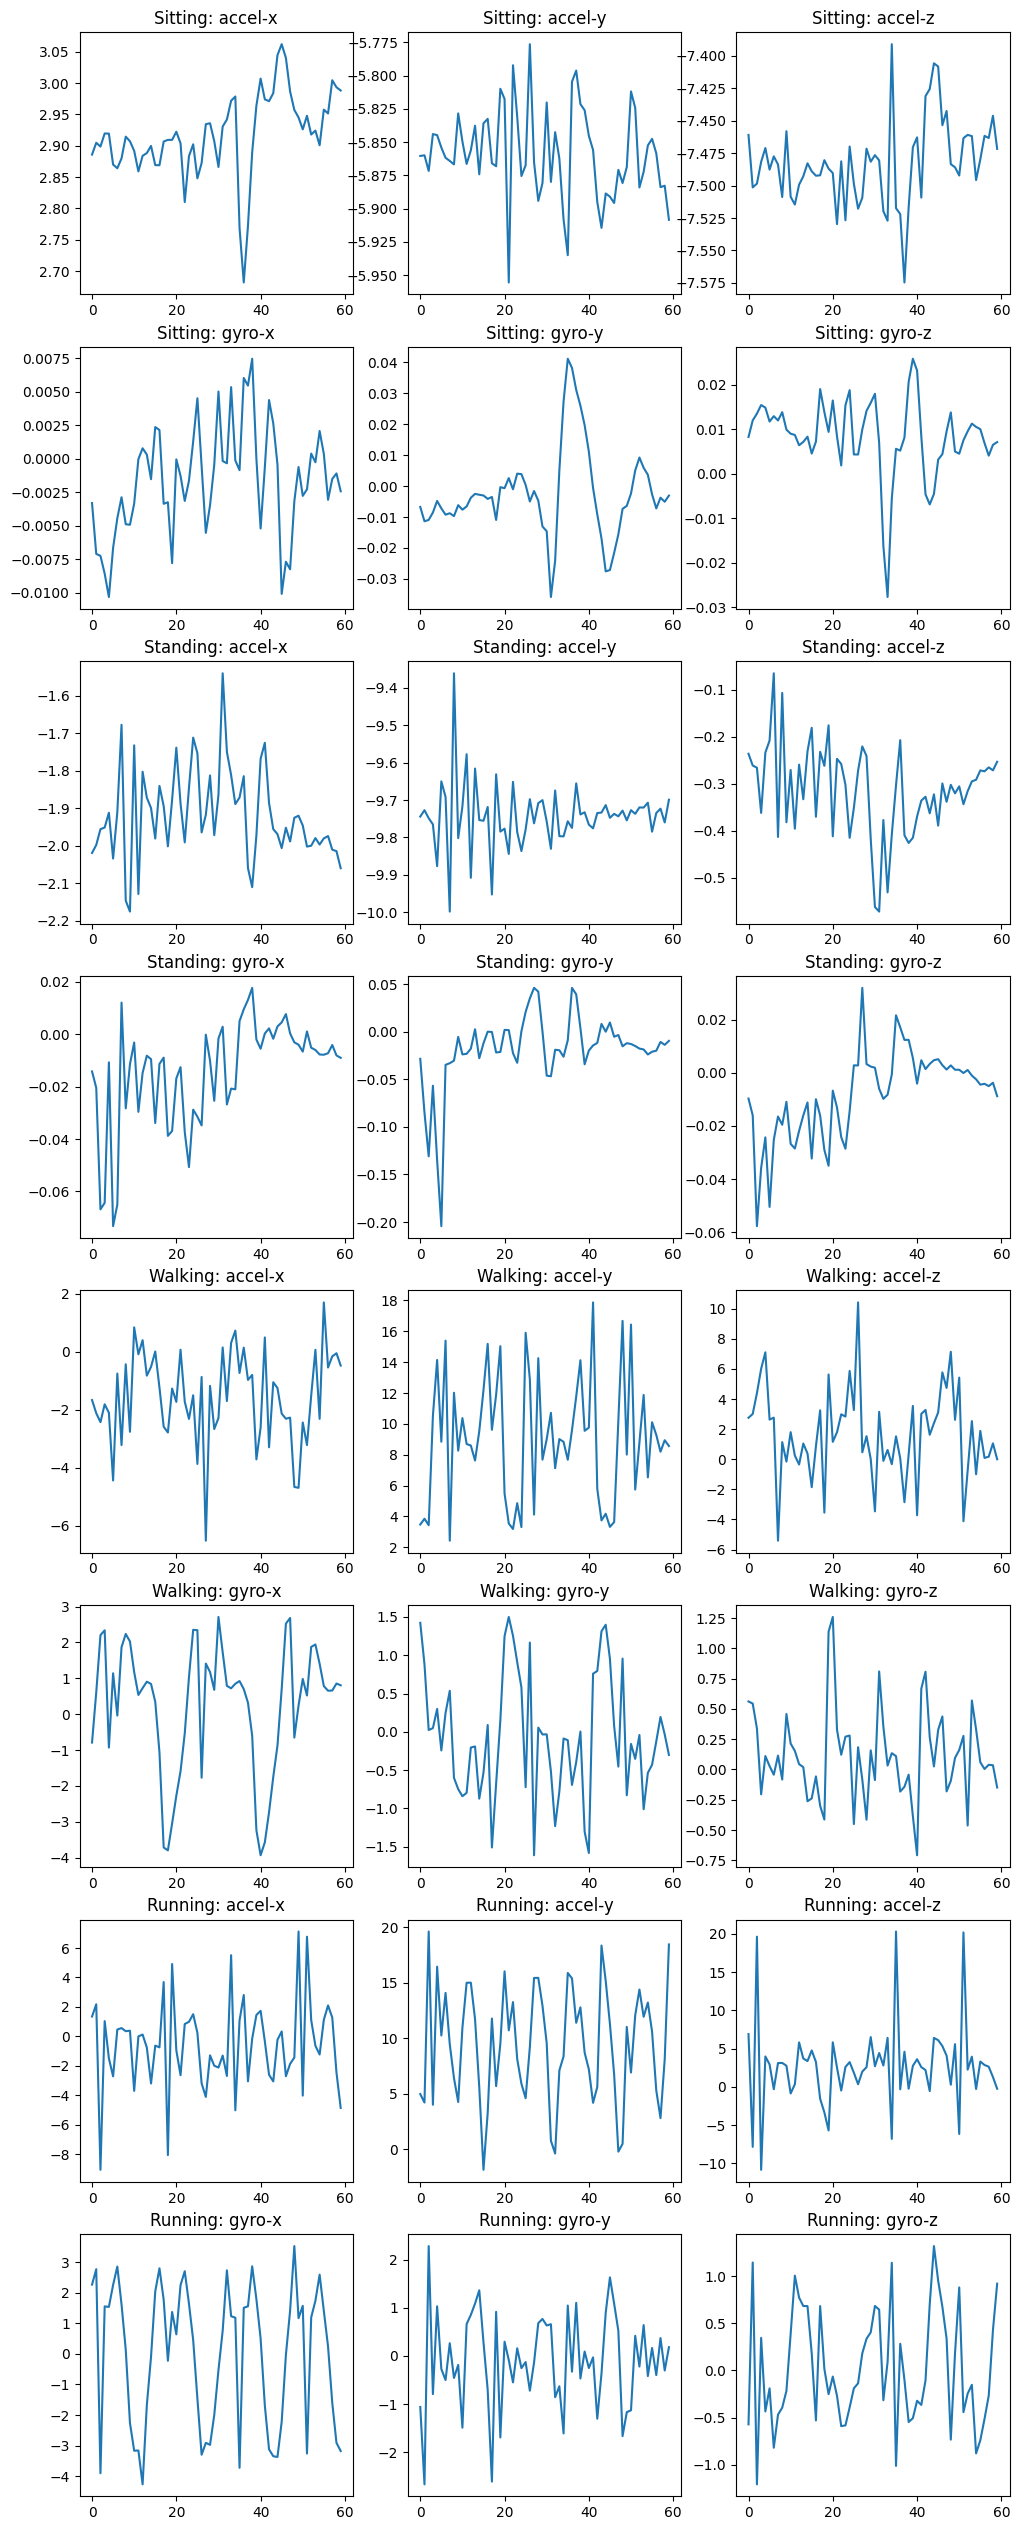

In [102]:
sensors = ('accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z')

fig, axs = plt.subplots(8, 3, figsize=(12, 32))

index_ax = 0
for code in label_map.keys():
    if (code != 4 and code != 3):
        filtered_train = data_train[data_train['standard activity code'] == code]
        sample = filtered_train.sample(random_state=42)
        for sensor in sensors:
            values = sample.loc[:,sensor+'-0':sensor+'-59'].values.T
            ax = axs.flat[index_ax]
            ax.plot(np.arange(60), values)
            ax.set_title(f"{label_map[code]}: {sensor}")

            index_ax += 1

plt.show()

In [108]:
def fft_transform_3(df):
    data = None
    for sensor in sensors:
        sensor_data = np.absolute(np.fft.fft(df.loc[:,sensor+'-0':sensor+'-59']))
        if data is None:
            data = sensor_data
        else:
            data = np.concatenate((data, sensor_data), axis=1)

    filler = df.loc[:,'accel-timestamp diff':'standard activity code']
    data = np.concatenate((data, filler), axis=1)
    fft_df = pd.DataFrame(data, columns=df.drop('Unnamed').columns)

    return fft_df

fft_train = fft_transform_3(data_train)
fft_val = fft_transform_3(data_val)
fft_test = fft_transform_3(data_test)

print(f"Dimensão do dataset de treinamento: {fft_train.shape}")
print(f"Dimensão do dataset de validação: {fft_val.shape}")
print(f"Dimensão do dataset de teste: {fft_test.shape}")

KeyError: "['Unnamed'] not found in axis"

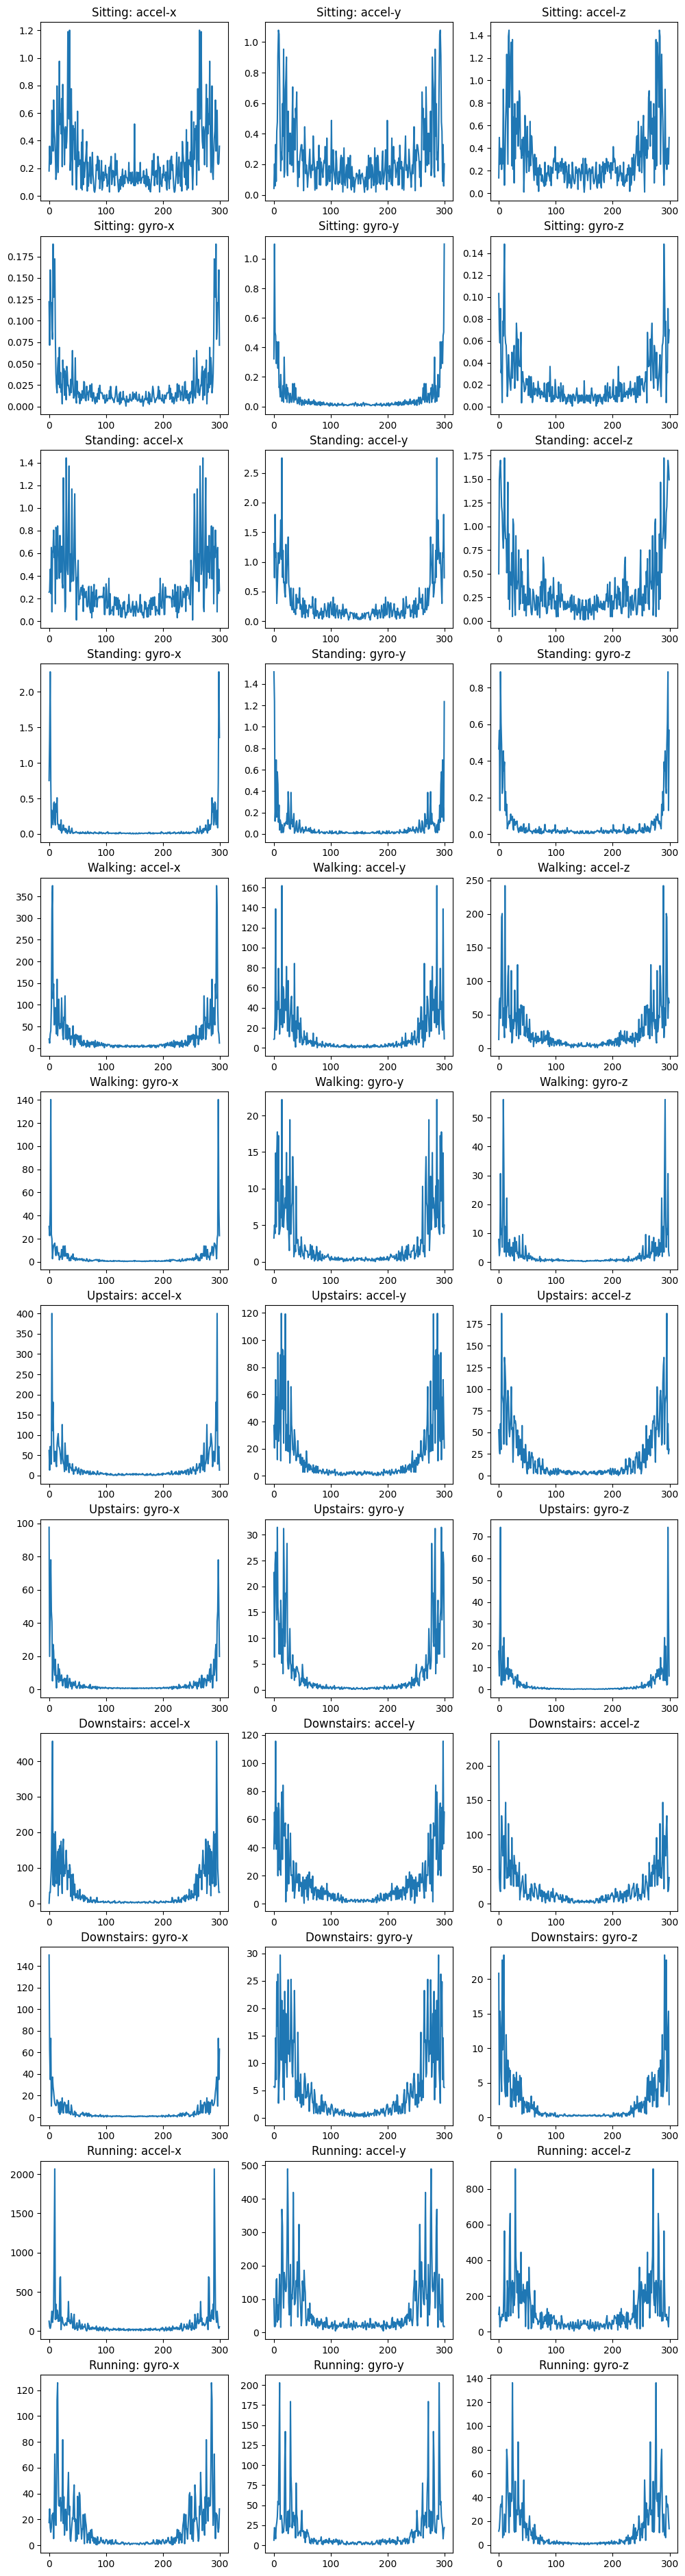

In [ ]:
fig, axs = plt.subplots(12, 3, figsize=(12, 48))

index_ax = 0
for code in label_map.keys():
    filtered_train = fft_train[fft_train['standard activity code'] == code]
    sample = filtered_train.sample(random_state=42)
    for sensor in sensors:
        values = sample.loc[:,sensor+'-0':sensor+'-299'].values.T
        ax = axs.flat[index_ax]
        ax.plot(np.arange(300), values)
        ax.set_title(f"{label_map[code]}: {sensor}")

        index_ax += 1

plt.show()

In [ ]:
from sklearn import manifold

""" Vamos usar uma técnica chamada t-SNE para mapear os dados numa representação 2D de forma não-linear buscando preservar as relações
    de vizinhança (probabilística) entre as amostras.
"""
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    #init="random",
    #random_state=0,
)

fft_concat_train = pd.concat((fft_train, fft_val))
X_t_sne = t_sne.fit_transform(fft_concat_train.loc[:,'accel-x-0':'gyro-z-299'])

#DataFrame com o resultado do t-SNE
tsne_result = pd.DataFrame(X_t_sne,columns=['tsne1','tsne2'])

In [ ]:
import plotly.express as px

fig = px.scatter(tsne_result, x='tsne1', y='tsne2', color=fft_concat_train["standard activity code"] ,labels={'color': 'Atividade'})

fig.update_layout(legend=dict(
    orientation="h",
    entrywidth=70,
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=0.8
))

fig.show()

In [ ]:
X_train = fft_train.loc[:,'accel-x-0':'gyro-z-299'].values
X_val = fft_val.loc[:,'accel-x-0':'gyro-z-299'].values
X_test = fft_test.loc[:,'accel-x-0':'gyro-z-299'].values

y_train = fft_train['standard activity code'].values.astype(int)
y_val = fft_val['standard activity code'].values.astype(int)
y_test = fft_test['standard activity code'].values.astype(int)

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

In [ ]:
n_features = X_train_val.shape[1]

# Define o grid de parâmetros
param_grid = {
    'C': np.logspace(-3, 1, 5),
    'gamma': np.logspace(-9, -3),
    'kernel': ['rbf', 'sigmoid']
}

#lista de índices para a separação novamente em X_train e X_val dentro do GridSearch
split_index = [-1]*len(X_train) + [0]*len(X_val)

#cria o splitter de dados
pds = PredefinedSplit(test_fold = split_index)

#define a busca em grade
grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=pds,
    verbose=2,
)


In [ ]:
grid.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 500 candidates, totalling 500 fits
[CV] END ...................C=0.001, gamma=1e-09, kernel=rbf; total time=   4.4s
[CV] END ...............C=0.001, gamma=1e-09, kernel=sigmoid; total time=   2.9s
[CV] END ..C=0.001, gamma=1.3257113655901108e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=1.3257113655901108e-09, kernel=sigmoid; total time=   3.3s
[CV] END ..C=0.001, gamma=1.7575106248547893e-09, kernel=rbf; total time=   3.7s
[CV] END C=0.001, gamma=1.7575106248547893e-09, kernel=sigmoid; total time=   3.5s
[CV] END ..C=0.001, gamma=2.3299518105153718e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=2.3299518105153718e-09, kernel=sigmoid; total time=   3.5s
[CV] END ...C=0.001, gamma=3.088843596477485e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=3.088843596477485e-09, kernel=sigmoid; total time=   2.9s
[CV] END ...C=0.001, gamma=4.094915062380419e-09, kernel=rbf; total time=   3.4s
[CV] END C=0.001, gamma=4.0949150623804

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'gamma': array([1.00000000e-09, 1.32571137e-09, 1.75751062e-09, 2.32995181e-09,
       3.08884360e-09, 4.09491506e-09, 5.42867544e-09, 7.19685673e-09,
       9.54095476e-09, 1.26485522e-08, 1.67683294e-08, 2.22299648e-08,
       2.94705170e-0...
       2.68269580e-06, 3.55648031e-06, 4.71486636e-06, 6.25055193e-06,
       8.28642773e-06, 1.09854114e-05, 1.45634848e-05, 1.93069773e-05,
       2.55954792e-05, 3.39322177e-05, 4.49843267e-05, 5.96362332e-05,
       7.90604321e-05, 1.04811313e-04, 1.38949549e-04, 1.84206997e-04,
       2.44205309e-04, 3.23745754e-04, 4.29193426e-04, 5.68986603e-04,
       7.54312006e-04, 1.00000000e-03]),
                         'kernel': ['rbf', 'sigmoid']},
             verbose=2)

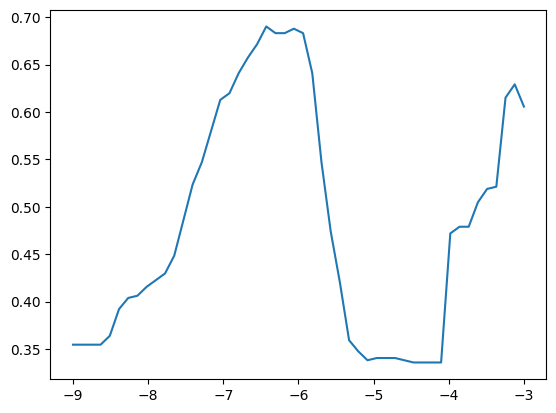

In [ ]:
# Score com C=0.1 e kernel='rbf', variando gamma
scores = grid.cv_results_['mean_test_score'][200:300:2]
gamma = np.linspace(-9, -3)

fig, ax = plt.subplots()
ax.plot(gamma, scores)
plt.show()

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names, zero_division=np.nan))
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

     Sitting       0.50      1.00      0.67        24
    Standing        nan      0.00      0.00        24
     Walking       0.81      0.92      0.86        24
    Upstairs       1.00      0.46      0.63        24
  Downstairs       0.56      0.42      0.48        24
     Running       0.60      1.00      0.75        24

    accuracy                           0.63       144
   macro avg       0.69      0.63      0.56       144
weighted avg       0.69      0.63      0.56       144

Acurácia: 0.6319444444444444
F1-score: 0.5640289449112978


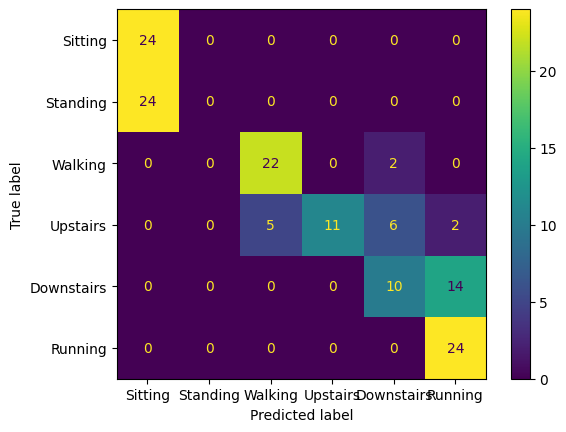

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names).plot()

In [ ]:
param_grid = {
    'n_neighbors': np.arange(1, 51),
    'p': (1, 2),
    'leaf_size': [int(x) for x in np.logspace(0, 2, 5)],
}

grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=pds,
    verbose=2,
)

In [ ]:
grid.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 500 candidates, totalling 500 fits
[CV] END ....................leaf_size=1, n_neighbors=1, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=1, p=2; total time=   0.4s
[CV] END ....................leaf_size=1, n_neighbors=2, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=2, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=3, p=1; total time=   2.3s
[CV] END ....................leaf_size=1, n_neighbors=3, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=4, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=4, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=5, p=1; total time=   2.0s
[CV] END ....................leaf_size=1, n_neighbors=5, p=2; total time=   0.5s
[CV] END ....................leaf_size=1, n_neighbors=6, p=1; total time=   2.1s
[CV] END ....................leaf_size=1, n_ne

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 3, 10, 31, 100],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                         'p': (1, 2)},
             verbose=2)

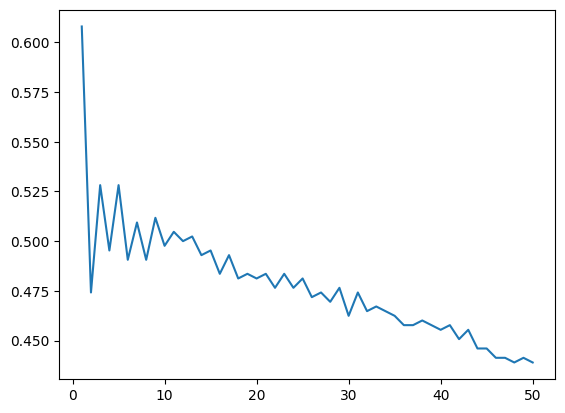

In [ ]:
# Score com leaf_size=1 e p=1
scores = grid.cv_results_['mean_test_score'][0:100:2]
n_neighbors = np.arange(1, 51)

fig, ax = plt.subplots()
ax.plot(n_neighbors, scores)
plt.show()

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names, zero_division=np.nan))
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

     Sitting       0.79      0.92      0.85        24
    Standing       0.90      0.75      0.82        24
     Walking       0.76      0.92      0.83        24
    Upstairs       0.80      0.50      0.62        24
  Downstairs       0.89      1.00      0.94        24
     Running       0.92      0.96      0.94        24

    accuracy                           0.84       144
   macro avg       0.84      0.84      0.83       144
weighted avg       0.84      0.84      0.83       144

Acurácia: 0.8402777777777778
F1-score: 0.8316434899596467


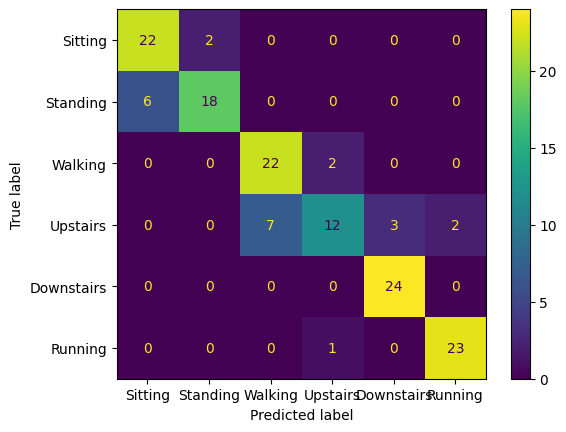

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names).plot()

In [ ]:
param_grid = {
    'n_estimators': np.arange(40, 1001, 40),
    'criterion': ('gini', 'entropy'),
    'min_samples_split': np.logspace(-4, 0, 3),
    'min_samples_leaf': np.logspace(-3, -1, 3)
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=pds,
    verbose=2,
)

In [ ]:
grid.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 450 candidates, totalling 450 fits
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=40; total time=   2.2s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=80; total time=   4.6s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=120; total time=   5.7s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=160; total time=   8.4s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=200; total time=  10.0s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=240; total time=  11.9s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=280; total time=  14.5s
[CV] END criterion=gini, min_samples_leaf=0.001, min_samples_split=0.0001, n_estimators=320; total time=  15.7s
[CV] END criterion=gini, min_samples_leaf=0

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'min_samples_leaf': array([0.001, 0.01 , 0.1  ]),
                         'min_samples_split': array([1.e-04, 1.e-02, 1.e+00]),
                         'n_estimators': array([  40,   80,  120,  160,  200,  240,  280,  320,  360,  400,  440,
        480,  520,  560,  600,  640,  680,  720,  760,  800,  840,  880,
        920,  960, 1000])},
             verbose=2)

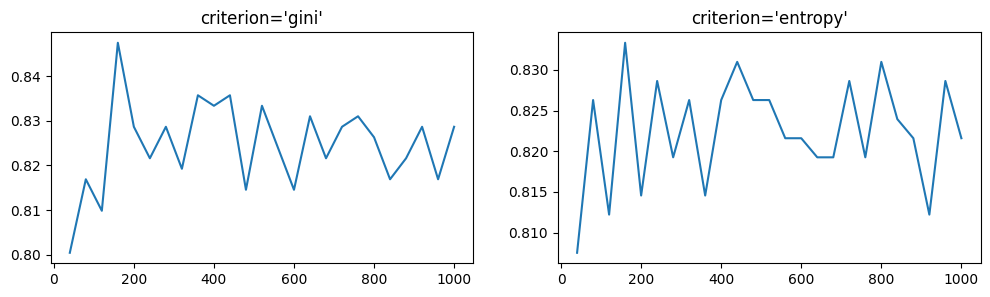

In [ ]:
# Score com min_samples_leaf=0.01 e min_samples_split=0.0001
scores_gini = grid.cv_results_['mean_test_score'][25:50:1]
scores_entropy = grid.cv_results_['mean_test_score'][250:275:]
n_estimators = np.arange(40, 1001, 40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.set_title("criterion='gini'")
ax1.plot(n_estimators, scores_gini)
ax2.set_title("criterion='entropy'")
ax2.plot(n_estimators, scores_entropy)
plt.show()

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names, zero_division=np.nan))
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

     Sitting       0.76      0.79      0.78        24
    Standing       0.78      0.75      0.77        24
     Walking       0.96      0.92      0.94        24
    Upstairs       0.88      0.62      0.73        24
  Downstairs       0.60      0.50      0.55        24
     Running       0.67      1.00      0.80        24

    accuracy                           0.76       144
   macro avg       0.77      0.76      0.76       144
weighted avg       0.77      0.76      0.76       144

Acurácia: 0.7638888888888888
F1-score: 0.7591332876973028


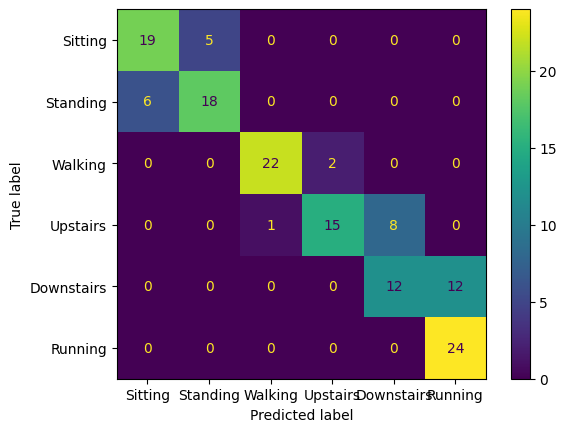

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names).plot()